# 1. Setup

## 1.1. Start neo4j docker container

In [118]:
import subprocess

subprocess.run(['docker', 'run',
                '--rm', '-d',
                '-e', 'NEO4J_AUTH=none',
                '-p', '7687:7687',
                '-p', '7474:7474',
                '--name', 'bench',
                'neo4j:3.5'])

from time import sleep, time
sleep(10)

## 1.2. Connect to neo4j

In [119]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver("bolt://localhost:7687", max_connection_pool_size=1_000_000)

## 1.3. Utility functions

In [120]:
def query(tx, q):
    return tx.run(q)

def du():
    return subprocess.run(['docker', 'exec', 'bench',
                           'du', '-bc', '/data'],
                          capture_output=True, encoding='utf-8')

def parse(proc):
    return float(proc.stdout.split('\n')[-2].split('\t')[0])

# 2. Benchmarks

## 2.1. Disk usage of nodes

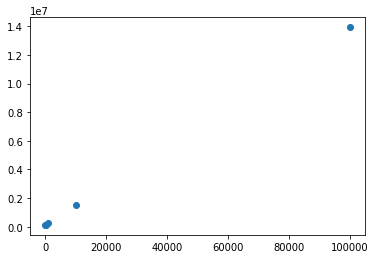

In [121]:
from concurrent.futures import ThreadPoolExecutor

x = [10 ** p for p in range(1, 6)]
y = []

# Results for other benchmarks but we collect it here so we don't have to recreate the scenario
isolated_node_creation_time = []

def do_work(q):
    with driver.session() as session:
        session.write_transaction(query, q)

c = 0
for i, n in enumerate(x):
    if i > 0:
        n -= x[i-1]  # Minus created nodes
        
    with ThreadPoolExecutor() as executor:
        q = 'create '
        for j in range(n):
            q += f'({{name: "n{c}"}}),'
            c += 1
            
            if j > 0 and j % 10000 == 0:
                q = q[:-1]
                executor.submit(do_work, q)
                q = 'create '
        if q != 'create ':
            q = q[:-1]
            do_work(q)
    
    y.append(int(parse(du())))
    
    # Results for other benchmarks
    start = time()
    with driver.session() as session:
        result = session.write_transaction(query, 'create (n) return n')
    isolated_node_creation_time.append((x[i], time() - start))
    added = result.values()[0][0]
    with driver.session() as session:
        session.write_transaction(query, f'match (n) where id(n)={added.id} delete n')
    
from matplotlib import pyplot as plt
import numpy as np
plt.scatter(x, y)

It seems disk space scale linearly with the number of nodes

In [122]:
import numpy as np

a, b = np.polyfit(x, y, 1)
big_x = [10 ** p for p in range(6, 10)]
big_y = [a * bx + b for bx in big_x]

### 2.1.1. Disk space vs no. nodes table (from 100M nodes onward is extrapolated)

In [123]:
import pandas as pd
from hurry.filesize import size
from millify import millify

df = pd.DataFrame({
    'No. nodes': [millify(t) for t in (x + big_x)],
    'Space (bytes)': [size(z) for z in (y + big_y)],
})
df

,No. nodes,Space (bytes)
0,10,129K
1,100,141K
2,1k,255K
3,10k,1M
4,100k,13M
5,1M,131M
6,10M,1G
7,100M,12G
8,1B,128G


## 2.2. Disk usage of edges

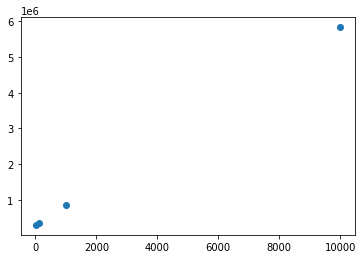

In [124]:
x = [10, 100, 1000, 10000]
y = []
y_nearest = []

n_nodes = 10 ** 5

def do_work(q):
    with driver.session() as session:
        session.write_transaction(query, q)

for i, n in enumerate(x):
    if i > 0:
        n -= x[i-1]
    if n == n_nodes:
        n -= 1

    with ThreadPoolExecutor() as executor:
        node = 0
        for neighbour in range(1, 1 + n):
            if i > 0:
                neighbour += sum(x[:i])
            neighbour %= n_nodes

            q = f'match (a),(b) where id(a)={node} and id(b)={neighbour} create (a)-[:Edge]->(b)'
            executor.submit(do_work, q)
    
    y.append(int(parse(du())) - 13 * 1024 ** 2)  # Minus ~13MB of 100K nodes
    
    start = time()
    with driver.session() as s:
        s.write_transaction(query, 'match (n)-[:Edge]-(m) where n.name = "n0" return m')
    y_nearest.append((x[i], time() - start))
    
from matplotlib import pyplot as plt
plt.scatter(x, y)

In [125]:
a, b = np.polyfit(x, y, 1)
big_x = [10 ** p for p in range(5, 7)]
big_y = [a * bx + b for bx in big_x]

df = pd.DataFrame({
    'No. edges': [millify(t) for t in (x + big_x)],
    'Space (bytes)': [size(z) for z in (y + big_y)],
})
df

,No. edges,Space (bytes)
0,10,291K
1,100,342K
2,1k,829K
3,10k,5M
4,100k,53M
5,1M,528M


### 2.2.1. Neo4j's article on disk usage: https://neo4j.com/developer/kb/understanding-data-on-disk/

## 2.3. Isolated node creation time w.r.t. number of nodes

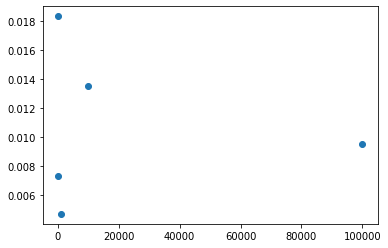

In [126]:
x, y = zip(*isolated_node_creation_time)
plt.scatter(x, y)

...constant time? (with random variation due to I/O)

## 2.4. Single node's creation & deletion time w.r.t. number of neighbours

### 2.4.1. Creation time

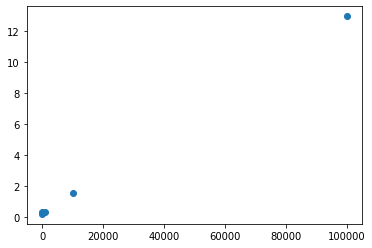

In [127]:
from time import time

x = [10, 100, 1000, 10000, 100000]
y = []
y_del = []

for i, n in enumerate(x):
    if n == n_nodes:
        n -= 1
        
    neighbours = [f'n{i}' for i in range(n)]
    q = f'match (a) where a.name in {neighbours} create (n {{name: "new"}}),(n)-[e:Edge]->(a) return n'

    start = time()
    with driver.session() as s:
        s.write_transaction(query, q)
    y.append(time() - start)
        
    start = time()
    with driver.session() as s:
        s.write_transaction(query, f'match (n),(n)-[e:Edge]->() where n.name = "new" delete e,n')
    y_del.append(time() - start)
    
from matplotlib import pyplot as plt
plt.scatter(x, y)

In [128]:
a, b = np.polyfit(x, y, 1)
big_x = [10 ** p for p in range(6, 8)]
big_y = [a * bx + b for bx in big_x]

df = pd.DataFrame({
    'No. edges on insert': [millify(t) for t in (x + big_x)],
    'Time (seconds)': [millify(z) for z in (y + big_y)],
})
df

,No. edges on insert,Time (seconds)
0,10,0
1,100,0
2,1k,0
3,10k,2
4,100k,13
5,1M,128
6,10M,1k


### 2.4.2. Deletion time

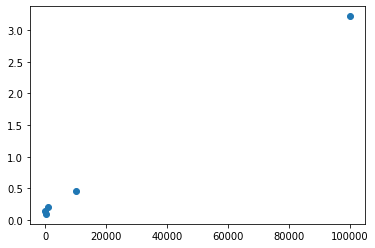

In [129]:
plt.scatter(x, y_del)

In [130]:
a, b = np.polyfit(x, y_del, 1)
big_x = [10 ** p for p in range(5, 8)]
big_y = [a * bx + b for bx in big_x]

df = pd.DataFrame({
    'No. edges on delete': [millify(t) for t in (x + big_x)],
    'Time (seconds)': [millify(z) for z in (y_del + big_y)],
})
df

,No. edges on delete,Time (seconds)
0,10,0
1,100,0
2,1k,0
3,10k,0
4,100k,3
5,100k,3
6,1M,31
7,10M,308


## 2.5. Nearest neighbours querying time w.r.t. no. neighbours

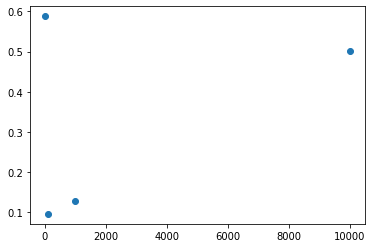

In [131]:
x, y = zip(*y_nearest)
plt.scatter(x, y)

In [133]:
a, b = np.polyfit(x, y, 1)
big_x = [10 ** p for p in range(5, 7)]
big_y = [a * bx + b for bx in big_x]

df = pd.DataFrame({
    'No. neighbours': [millify(t) for t in (list(x) + big_x)],
    'Time (seconds)': [millify(z) for z in (list(y) + big_y)],
})
df

,No. neighbours,Time (seconds)
0,10,1
1,100,0
2,1k,0
3,10k,1
4,100k,2
5,1M,22


# Clean up

In [117]:
driver.close()
subprocess.run(['docker', 'stop', 'bench'])

CompletedProcess(args=['docker', 'stop', 'bench'], returncode=0)